<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/da_cv_fer_sfew_expw_v17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes :

- use of misclassification images
- Use of BespokeDANN without attention
- Epochs increased from 60 to 150
- Scheduler based on val loss and not training loss, absolute value

Observations:

- The VAL loss is not stable, it rises up after getting a minima
appears that accuracy NON-DANN () > EWC () > DANN ()
- The training accuracy is around 78%, which means underfit, this may be because of augmentation
- reduce augmentation in next step
- include regularlization
- looks like lr scheduling in DANN and DANN EWC is not working

Models:
- 25_02



## Cloning repository
Importing files regarding dataset, model, mains and utils

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 309 (delta 48), reused 66 (delta 32), pack-reused 209
Receiving objects: 100% (309/309), 15.68 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (162/162), done.


Installing dependencies

In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

## Libraries and Initializations

In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
from da_cv_fer.model_DANN import DANN
from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [5]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# sfew = DatasetSFEW()
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Di

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# show_batch(sfew_train_loader,sfew.labels,4)

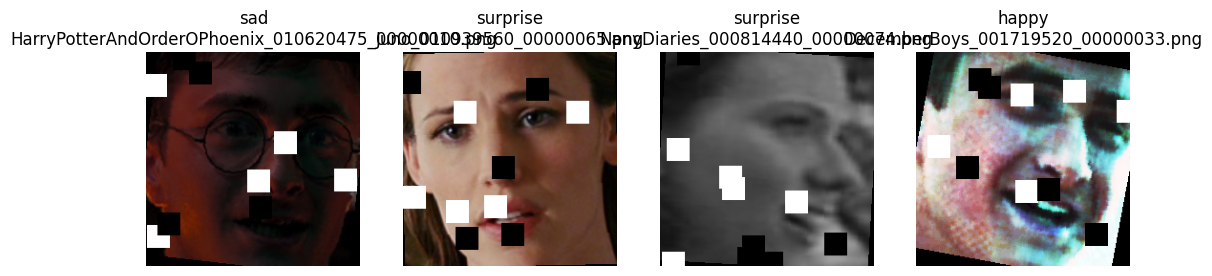

In [8]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [9]:
# expw_obj = EXPW()
expw_obj = EXPWCROP()

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
in EXPW()...
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [01:17<00:00, 107MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 
635 cropped images created in cropped
 length of EXPW dataset : 646 , 646


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

In [ ]:
show_batch(expw_train_loader,expw_train_ds.labels,3, normalized = False)

## Creating Dataloaders for source and target

In [ ]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']


In [13]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }

expw_loader = {'name': 'expw',
               'train':expw_train_loader,
               'val':expw_val_loader
               }

data_loader = {'source' : sfew_loader,
               'target' : expw_loader}

source_name = data_loader['source']['name']
target_name = data_loader['target']['name']

## Initializing Model
details are present in `model_DANN`

In [14]:
model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False) #DANN(num_classes=7,backbone='mobilenet', dropout=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.1MB/s]


feature extractor backbone created using mobilenet model


In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

cuda


Running model for single run. checking output shapes

In [16]:
for usage, dict_data_loader in data_loader.items(): ## {'source' : sfew_loader,'target' : expw_loader}
    print('-'*80)
    print(usage)
    for k, v in dict_data_loader.items(): # {'name': 'sfew','train':sfew_train_loader,'val':sfew_val_loader}
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ", labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ", domains: ",x_domains.shape, ", features: ", x_features.shape)


--------------------------------------------------------------------------------
source
--------name of dataset : sfew--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1280])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1280])
--------------------------------------------------------------------------------
target
--------name of dataset : expw--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1280])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , l

Checking Misclassification images

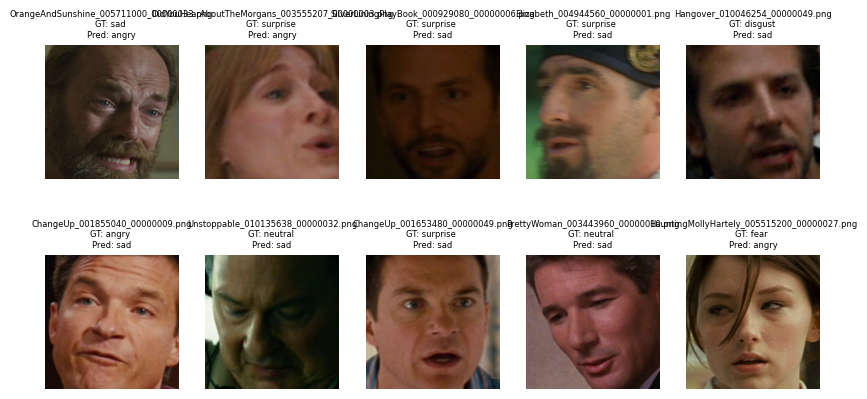

In [17]:
  list_misclassified_images = get_misclassified_images_list(model= model,
                                                            device = device,
                                                            test_loader = data_loader['source']['val'],
                                                            num_image = 10)
  plot_misclassified_images(list_misclassified_images,
                            labels = sfew.labels)

In [18]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

## Non DANN: Training, Validating, Saving

### Early Stopping Scheduler - ReduceLRonPlateau

In [19]:
# def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
#   if len(list_loss) > patience:
#     reverse_list_loss = list_loss[::-1]
#     reverse_list_loss = reverse_list_loss[0:patience+1]
#     for index in range(0,len(reverse_list_loss)-1):
#       if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
#         return False
#     return True
#   else:
#     return False

Configuration towards execution

In [34]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False) #DANN(num_classes=7, backbone = 'mobilenet')
non_dann_model = non_dann_model.to(device)
best_non_dann_model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False) #DANN(num_classes=7, backbone = 'mobilenet').to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 5 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

feature extractor backbone created using mobilenet model
feature extractor backbone created using mobilenet model
EPOCHS 150


------ Training started for Non DANN Model ---- 
starting LR : 0.005
EPOCH: 1  of  150
epoch = 1...in training function


  0%|          | 0/58 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.5072160959243774 Accuracy=238/913(26.07%) Epoch Avg loss=0.11634909 LR=0.005000: 100%|██████████| 58/58 [00:11<00:00,  5.26it/s]


Test / Val: Average loss: 0.1232, Accuracy: 77/419 (18.38%)

last correct =77 | best correct = 83


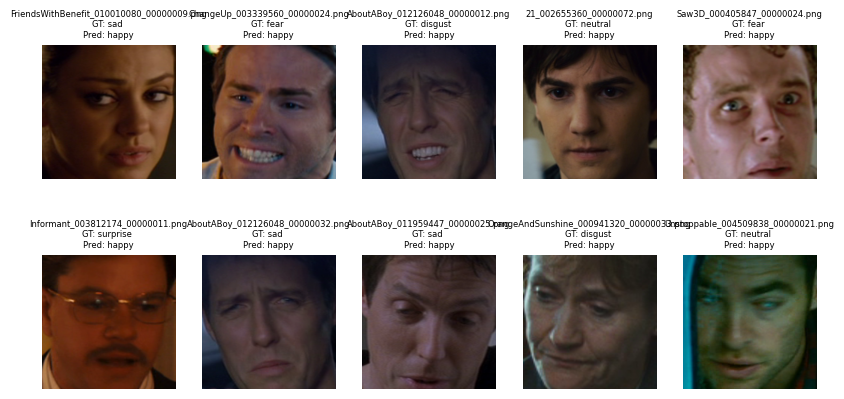

EPOCH: 2  of  150
epoch = 2...in training function


Loss=2.500941753387451 Accuracy=223/913(24.42%) Epoch Avg loss=0.11629750 LR=0.005000: 100%|██████████| 58/58 [00:11<00:00,  4.94it/s]


Test / Val: Average loss: 0.1218, Accuracy: 90/419 (21.48%)

last correct =90 | best correct = 83
Updated the best model with correct: 90

EPOCH: 3  of  150
epoch = 3...in training function


Loss=1.6171858310699463 Accuracy=269/913(29.46%) Epoch Avg loss=0.11222053 LR=0.005000: 100%|██████████| 58/58 [00:11<00:00,  5.06it/s]


Test / Val: Average loss: 0.1157, Accuracy: 104/419 (24.82%)

last correct =104 | best correct = 90
Updated the best model with correct: 104

EPOCH: 4  of  150
epoch = 4...in training function


Loss=1.8841501474380493 Accuracy=277/913(30.34%) Epoch Avg loss=0.10898177 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.30it/s]


Test / Val: Average loss: 0.1139, Accuracy: 129/419 (30.79%)

last correct =129 | best correct = 104
Updated the best model with correct: 129

EPOCH: 5  of  150
epoch = 5...in training function


Loss=1.8208154439926147 Accuracy=328/913(35.93%) Epoch Avg loss=0.10525446 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.58it/s]


Test / Val: Average loss: 0.1162, Accuracy: 116/419 (27.68%)

last correct =116 | best correct = 129
EPOCH: 6  of  150
epoch = 6...in training function


Loss=1.5777194499969482 Accuracy=343/913(37.57%) Epoch Avg loss=0.10357006 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.75it/s]


Test / Val: Average loss: 0.1175, Accuracy: 109/419 (26.01%)

last correct =109 | best correct = 129
EPOCH: 7  of  150
epoch = 7...in training function


Loss=1.6002881526947021 Accuracy=331/913(36.25%) Epoch Avg loss=0.10240644 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.73it/s]


Test / Val: Average loss: 0.1151, Accuracy: 124/419 (29.59%)

last correct =124 | best correct = 129
EPOCH: 8  of  150
epoch = 8...in training function


Loss=1.7380504608154297 Accuracy=363/913(39.76%) Epoch Avg loss=0.09944444 LR=0.005000: 100%|██████████| 58/58 [00:09<00:00,  5.93it/s]


Test / Val: Average loss: 0.1131, Accuracy: 120/419 (28.64%)

last correct =120 | best correct = 129
EPOCH: 9  of  150
epoch = 9...in training function


Loss=1.6890450716018677 Accuracy=401/913(43.92%) Epoch Avg loss=0.09626483 LR=0.005000: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


Test / Val: Average loss: 0.1188, Accuracy: 148/419 (35.32%)

last correct =148 | best correct = 129
Updated the best model with correct: 148

EPOCH: 10  of  150
epoch = 10...in training function


Loss=2.216054677963257 Accuracy=383/913(41.95%) Epoch Avg loss=0.09565403 LR=0.005000: 100%|██████████| 58/58 [00:09<00:00,  5.98it/s]


Test / Val: Average loss: 0.1104, Accuracy: 145/419 (34.61%)

last correct =145 | best correct = 148
EPOCH: 11  of  150
epoch = 11...in training function


Loss=2.334165573120117 Accuracy=433/913(47.43%) Epoch Avg loss=0.08903816 LR=0.005000: 100%|██████████| 58/58 [00:09<00:00,  5.84it/s]


Test / Val: Average loss: 0.1075, Accuracy: 159/419 (37.95%)

last correct =159 | best correct = 148
Updated the best model with correct: 159



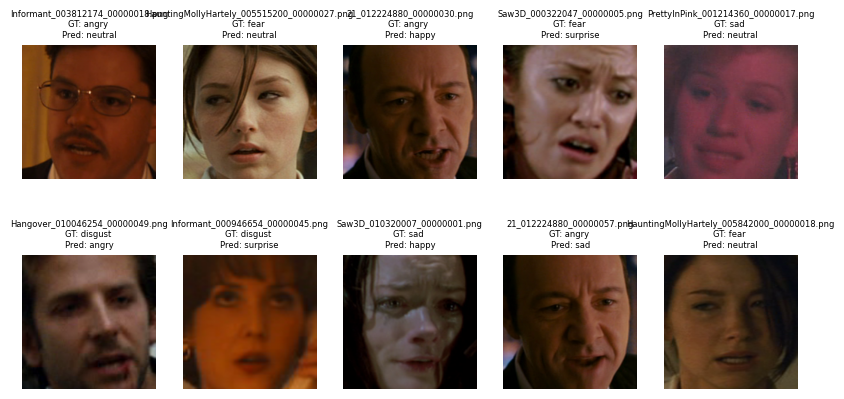

EPOCH: 12  of  150
epoch = 12...in training function


Loss=2.072880744934082 Accuracy=432/913(47.32%) Epoch Avg loss=0.08956004 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.57it/s]


Test / Val: Average loss: 0.1126, Accuracy: 160/419 (38.19%)

last correct =160 | best correct = 159
Updated the best model with correct: 160

EPOCH: 13  of  150
epoch = 13...in training function


Loss=2.2734947204589844 Accuracy=443/913(48.52%) Epoch Avg loss=0.08955883 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.66it/s]


Test / Val: Average loss: 0.1035, Accuracy: 178/419 (42.48%)

last correct =178 | best correct = 160
Updated the best model with correct: 178

EPOCH: 14  of  150
epoch = 14...in training function


Loss=1.8122618198394775 Accuracy=452/913(49.51%) Epoch Avg loss=0.08514019 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.53it/s]


Test / Val: Average loss: 0.1050, Accuracy: 175/419 (41.77%)

last correct =175 | best correct = 178
EPOCH: 15  of  150
epoch = 15...in training function


Loss=1.653602123260498 Accuracy=470/913(51.48%) Epoch Avg loss=0.08549000 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.58it/s]


Test / Val: Average loss: 0.1039, Accuracy: 168/419 (40.10%)

last correct =168 | best correct = 178
EPOCH: 16  of  150
epoch = 16...in training function


Loss=2.137878656387329 Accuracy=510/913(55.86%) Epoch Avg loss=0.07891833 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.58it/s]


Test / Val: Average loss: 0.1110, Accuracy: 168/419 (40.10%)

last correct =168 | best correct = 178
EPOCH: 17  of  150
epoch = 17...in training function


Loss=2.4770987033843994 Accuracy=501/913(54.87%) Epoch Avg loss=0.07708572 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.63it/s]


Test / Val: Average loss: 0.1035, Accuracy: 162/419 (38.66%)

last correct =162 | best correct = 178
EPOCH: 18  of  150
epoch = 18...in training function


Loss=1.7939927577972412 Accuracy=525/913(57.50%) Epoch Avg loss=0.07511884 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.63it/s]


Test / Val: Average loss: 0.1026, Accuracy: 181/419 (43.20%)

last correct =181 | best correct = 178
Updated the best model with correct: 181

EPOCH: 19  of  150
epoch = 19...in training function


Loss=1.8854939937591553 Accuracy=523/913(57.28%) Epoch Avg loss=0.07575108 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.61it/s]


Test / Val: Average loss: 0.1086, Accuracy: 176/419 (42.00%)

last correct =176 | best correct = 181
EPOCH: 20  of  150
epoch = 20...in training function


Loss=2.105368137359619 Accuracy=534/913(58.49%) Epoch Avg loss=0.07198144 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.62it/s]


Test / Val: Average loss: 0.1071, Accuracy: 173/419 (41.29%)

last correct =173 | best correct = 181
EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.7342138886451721 Accuracy=573/913(62.76%) Epoch Avg loss=0.06714555 LR=0.005000: 100%|██████████| 58/58 [00:10<00:00,  5.73it/s]


Test / Val: Average loss: 0.1133, Accuracy: 161/419 (38.42%)

last correct =161 | best correct = 181


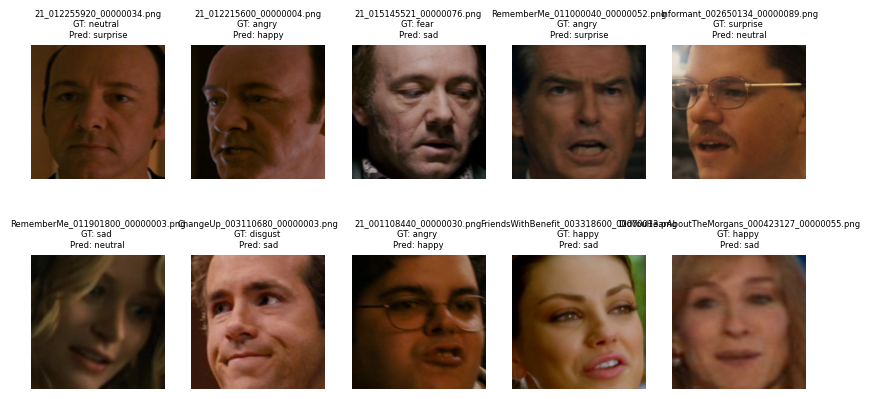

EPOCH: 22  of  150
epoch = 22...in training function


Loss=1.9589853286743164 Accuracy=588/913(64.40%) Epoch Avg loss=0.06269356 LR=0.005000: 100%|██████████| 58/58 [00:11<00:00,  5.03it/s]


Test / Val: Average loss: 0.1067, Accuracy: 168/419 (40.10%)

Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.
last correct =168 | best correct = 181
EPOCH: 23  of  150
epoch = 23...in training function


Loss=1.936760425567627 Accuracy=628/913(68.78%) Epoch Avg loss=0.05865975 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.10it/s]


Test / Val: Average loss: 0.1038, Accuracy: 186/419 (44.39%)

last correct =186 | best correct = 181
Updated the best model with correct: 186

EPOCH: 24  of  150
epoch = 24...in training function


Loss=1.1988980770111084 Accuracy=660/913(72.29%) Epoch Avg loss=0.05130020 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.06it/s]


Test / Val: Average loss: 0.1094, Accuracy: 187/419 (44.63%)

last correct =187 | best correct = 186
Updated the best model with correct: 187

EPOCH: 25  of  150
epoch = 25...in training function


Loss=1.3433458805084229 Accuracy=646/913(70.76%) Epoch Avg loss=0.05241631 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.25it/s]


Test / Val: Average loss: 0.1082, Accuracy: 184/419 (43.91%)

last correct =184 | best correct = 187
EPOCH: 26  of  150
epoch = 26...in training function


Loss=1.6590958833694458 Accuracy=665/913(72.84%) Epoch Avg loss=0.05047442 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]


Test / Val: Average loss: 0.1104, Accuracy: 175/419 (41.77%)

last correct =175 | best correct = 187
EPOCH: 27  of  150
epoch = 27...in training function


Loss=1.9823477268218994 Accuracy=673/913(73.71%) Epoch Avg loss=0.04933781 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.12it/s]


Test / Val: Average loss: 0.1079, Accuracy: 181/419 (43.20%)

last correct =181 | best correct = 187
EPOCH: 28  of  150
epoch = 28...in training function


Loss=1.6064834594726562 Accuracy=674/913(73.82%) Epoch Avg loss=0.04591406 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.22it/s]


Test / Val: Average loss: 0.1089, Accuracy: 191/419 (45.58%)

last correct =191 | best correct = 187
Updated the best model with correct: 191

EPOCH: 29  of  150
epoch = 29...in training function


Loss=1.6543190479278564 Accuracy=693/913(75.90%) Epoch Avg loss=0.04600511 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.25it/s]


Test / Val: Average loss: 0.1159, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 191
EPOCH: 30  of  150
epoch = 30...in training function


Loss=1.5674960613250732 Accuracy=704/913(77.11%) Epoch Avg loss=0.04263818 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.21it/s]


Test / Val: Average loss: 0.1128, Accuracy: 185/419 (44.15%)

last correct =185 | best correct = 191
EPOCH: 31  of  150
epoch = 31...in training function


Loss=1.7545475959777832 Accuracy=698/913(76.45%) Epoch Avg loss=0.04400194 LR=0.001000: 100%|██████████| 58/58 [00:11<00:00,  5.27it/s]


Test / Val: Average loss: 0.1195, Accuracy: 169/419 (40.33%)

Epoch 00034: reducing learning rate of group 0 to 2.0000e-04.
last correct =169 | best correct = 191


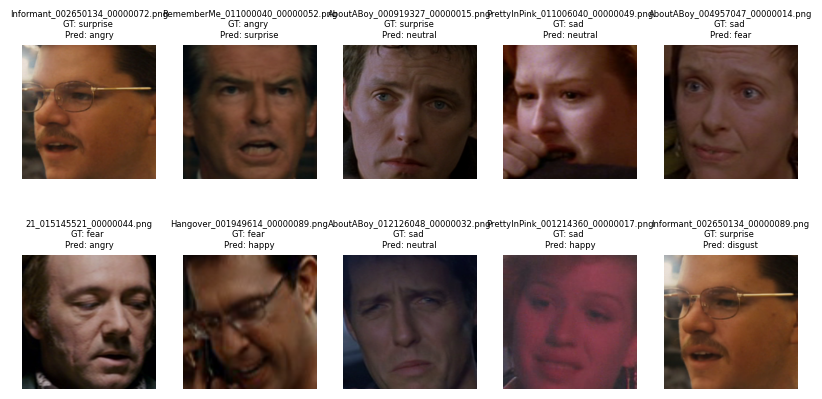

EPOCH: 32  of  150
epoch = 32...in training function


Loss=1.8039666414260864 Accuracy=701/913(76.78%) Epoch Avg loss=0.04430522 LR=0.000200: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


Test / Val: Average loss: 0.1182, Accuracy: 177/419 (42.24%)

last correct =177 | best correct = 191
EPOCH: 33  of  150
epoch = 33...in training function


Loss=1.0174896717071533 Accuracy=715/913(78.31%) Epoch Avg loss=0.04072534 LR=0.000200: 100%|██████████| 58/58 [00:12<00:00,  4.69it/s]


Test / Val: Average loss: 0.1194, Accuracy: 178/419 (42.48%)

last correct =178 | best correct = 191
EPOCH: 34  of  150
epoch = 34...in training function


Loss=1.5005639791488647 Accuracy=707/913(77.44%) Epoch Avg loss=0.03993150 LR=0.000200: 100%|██████████| 58/58 [00:12<00:00,  4.71it/s]


Test / Val: Average loss: 0.1148, Accuracy: 179/419 (42.72%)

last correct =179 | best correct = 191
EPOCH: 35  of  150
epoch = 35...in training function


Loss=1.490039348602295 Accuracy=711/913(77.88%) Epoch Avg loss=0.04121201 LR=0.000200: 100%|██████████| 58/58 [00:11<00:00,  4.97it/s]


Test / Val: Average loss: 0.1142, Accuracy: 189/419 (45.11%)

last correct =189 | best correct = 191
EPOCH: 36  of  150
epoch = 36...in training function


Loss=1.3162997961044312 Accuracy=697/913(76.34%) Epoch Avg loss=0.04177487 LR=0.000200: 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]


Test / Val: Average loss: 0.1124, Accuracy: 183/419 (43.68%)

last correct =183 | best correct = 191
EPOCH: 37  of  150
epoch = 37...in training function


Loss=1.1844773292541504 Accuracy=717/913(78.53%) Epoch Avg loss=0.04061114 LR=0.000200: 100%|██████████| 58/58 [00:11<00:00,  5.24it/s]


Test / Val: Average loss: 0.1182, Accuracy: 185/419 (44.15%)

last correct =185 | best correct = 191
EPOCH: 38  of  150
epoch = 38...in training function


Loss=1.28273606300354 Accuracy=712/913(77.98%) Epoch Avg loss=0.03980649 LR=0.000200: 100%|██████████| 58/58 [00:11<00:00,  4.94it/s]


Test / Val: Average loss: 0.1159, Accuracy: 175/419 (41.77%)

last correct =175 | best correct = 191
EPOCH: 39  of  150
epoch = 39...in training function


Loss=1.6616060733795166 Accuracy=710/913(77.77%) Epoch Avg loss=0.04222589 LR=0.000200: 100%|██████████| 58/58 [00:11<00:00,  5.05it/s]


Test / Val: Average loss: 0.1148, Accuracy: 189/419 (45.11%)

last correct =189 | best correct = 191
EPOCH: 40  of  150
epoch = 40...in training function


Loss=1.4056620597839355 Accuracy=720/913(78.86%) Epoch Avg loss=0.04050883 LR=0.000200: 100%|██████████| 58/58 [00:11<00:00,  5.02it/s]


Test / Val: Average loss: 0.1144, Accuracy: 183/419 (43.68%)

Epoch 00043: reducing learning rate of group 0 to 4.0000e-05.
last correct =183 | best correct = 191
EPOCH: 41  of  150
epoch = 41...in training function


Loss=1.5079315900802612 Accuracy=710/913(77.77%) Epoch Avg loss=0.04133764 LR=0.000040: 100%|██████████| 58/58 [00:11<00:00,  5.04it/s]


Test / Val: Average loss: 0.1163, Accuracy: 176/419 (42.00%)

last correct =176 | best correct = 191
-------Early Stopping at epoch 41---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.1072, Accuracy: 191/419 (45.58%)

Test results with expw
Test / Val: Average loss: 0.3062, Accuracy: 1/34 (2.94%)



In [36]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    # #Adding Scheduler #TODO: ADD SCHEDULER
    # scheduler.step(avg_epoch_loss) #applying scheduler on training loss

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(non_dann_model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= non_dann_model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  non_dann_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model(model= non_dann_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)

print(f'Test results with {target_name}')
correct, test_loss_target = test_model(model= non_dann_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['target']['val'], # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}




In [ ]:
#checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), best_non_dann_model.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
#         break
# print ('True')

In [37]:
print(dict_non_dann_losses)

{'train_losses': [0.12187734, 0.1193943, 0.11899367, 0.11634909, 0.1162975, 0.11222053, 0.10898177, 0.10525446, 0.10357006, 0.10240644, 0.09944444, 0.09626483, 0.09565403, 0.08903816, 0.08956004, 0.08955883, 0.08514019, 0.08549, 0.07891833, 0.07708572, 0.07511884, 0.07575108, 0.07198144, 0.06714555, 0.06269356, 0.05865975, 0.0513002, 0.05241631, 0.05047442, 0.04933781, 0.04591406, 0.04600511, 0.04263818, 0.04400194, 0.04430522, 0.04072534, 0.0399315, 0.04121201, 0.04177487, 0.04061114, 0.03980649, 0.04222589, 0.04050883, 0.04133764], 'val_losses': [0.1229372212312102, 0.12194066684968716, 0.12153528271540821, 0.12324277626301622, 0.12178900475149224, 0.11572820047774576, 0.11390599231446842, 0.11619915029029573, 0.11751753276743013, 0.11513569360701167, 0.11309071856068541, 0.11882362416934285, 0.11042642109718413, 0.10753295700419205, 0.11264494922109891, 0.1034545332264502, 0.10497844674422234, 0.10386913004809177, 0.11098916547679674, 0.1035125861588981, 0.10257922322767161, 0.10860

In [ ]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_losses, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_losses[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

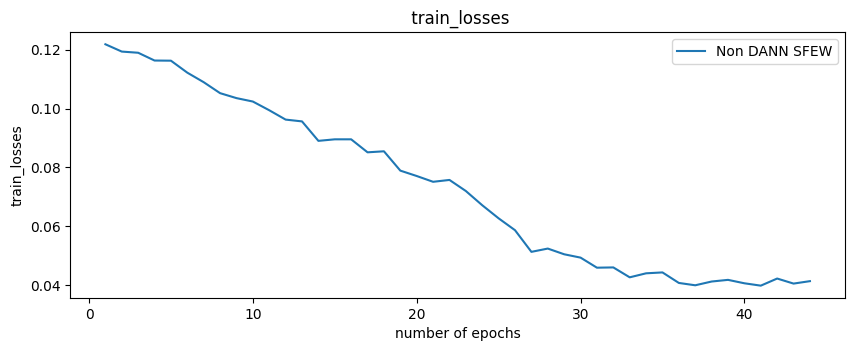

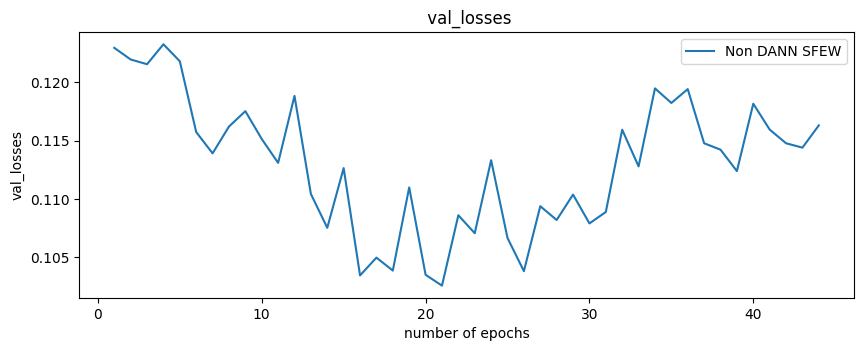

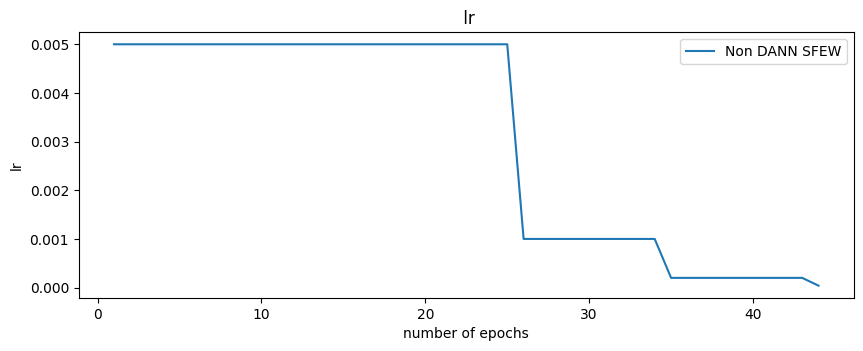

In [38]:
plot_loss_curves(dict_non_dann_losses,mode='train_losses')
plot_loss_curves(dict_non_dann_losses,mode='val_losses')
plot_loss_curves(dict_non_dann_losses,mode='lr')

### Saving NON DANN Model

In [39]:
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [40]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [ ]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_non_dann_losses_list, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_non_dann_losses_list[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

In [ ]:
# plot_loss_curves(dict_non_dann_losses_list,mode='train_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='val_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='lr')

In [ ]:
# model_name = model_name #"non_dann_sfew_19_12.pt"

## Loading NON DANN Model for DANN and DANN EWC


In [41]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
model_name

'non_dann_sfew_expw_25_02.pt'

In [ ]:
# best_model_dann = DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
# best_model_dann_ewc = DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
# model_dann = deepcopy(non_dann_model) # saves training time - check with all
# model_dann_ewc = deepcopy(non_dann_model) # saves training time - check with all

In [42]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

loaded_model_non_dann = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False)  # skeleton copy
best_model_dann = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False)  # skeleton copy
best_model_dann_ewc = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False) .to(device) # skeleton copy

loaded_model_non_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

# loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = deepcopy(loaded_model_non_dann) # saves training time - check with all
model_dann_ewc = deepcopy(loaded_model_non_dann) # saves training time - check with all


# print(model_dann)

feature extractor backbone created using mobilenet model
feature extractor backbone created using mobilenet model
feature extractor backbone created using mobilenet model


In [ ]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

## DANN Execution :  Training, Validating, Saving


### DANN Execution Function

In [44]:

def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(non_dann_model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





------------training started for DANN Model ------------------
epoch = 1...in DANN execution function


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch[1/150] Step[1/41]: loss_total=2.2261 / domain_loss_target=0.6892 / domain_loss_source=0.7003 / task_loss=0.8366 / domain_loss=1.5369 / alpha=0.00 / lr=0.001000
Epoch[1/150] Step[11/41]: loss_total=1.8402 / domain_loss_target=0.6963 / domain_loss_source=0.6867 / task_loss=0.4572 / domain_loss=1.1439 / alpha=0.01 / lr=0.001000
Epoch[1/150] Step[21/41]: loss_total=1.9208 / domain_loss_target=0.6945 / domain_loss_source=0.6915 / task_loss=0.5348 / domain_loss=1.2263 / alpha=0.02 / lr=0.001000
Epoch[1/150] Step[31/41]: loss_total=2.1958 / domain_loss_target=0.6935 / domain_loss_source=0.6928 / task_loss=0.8095 / domain_loss=1.5023 / alpha=0.02 / lr=0.001000
Test / Val: Average loss: 0.1160, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 0
Updated the best model with correct: 180



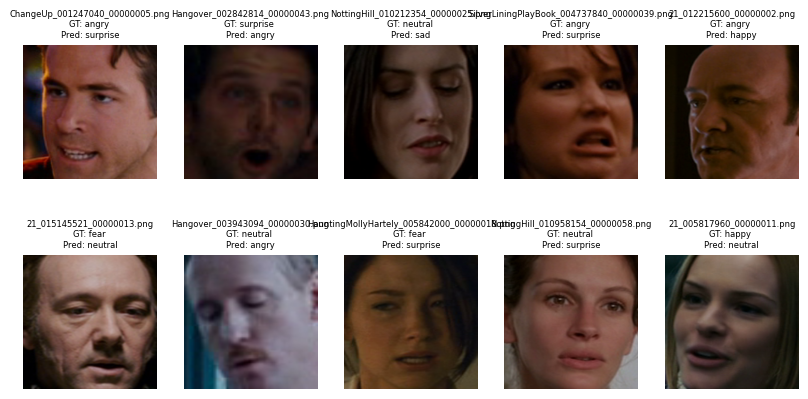

epoch = 2...in DANN execution function
Epoch[2/150] Step[1/41]: loss_total=2.0853 / domain_loss_target=0.6959 / domain_loss_source=0.6927 / task_loss=0.6967 / domain_loss=1.3895 / alpha=0.03 / lr=0.001000
Epoch[2/150] Step[11/41]: loss_total=1.9164 / domain_loss_target=0.6949 / domain_loss_source=0.6923 / task_loss=0.5292 / domain_loss=1.2215 / alpha=0.04 / lr=0.001000
Epoch[2/150] Step[21/41]: loss_total=2.0401 / domain_loss_target=0.7004 / domain_loss_source=0.6902 / task_loss=0.6495 / domain_loss=1.3397 / alpha=0.05 / lr=0.001000
Epoch[2/150] Step[31/41]: loss_total=1.8381 / domain_loss_target=0.6999 / domain_loss_source=0.6835 / task_loss=0.4547 / domain_loss=1.1382 / alpha=0.06 / lr=0.001000
Test / Val: Average loss: 0.1222, Accuracy: 182/419 (43.44%)

last correct =182 | best correct = 180
Updated the best model with correct: 182

epoch = 3...in DANN execution function
Epoch[3/150] Step[1/41]: loss_total=1.8140 / domain_loss_target=0.6963 / domain_loss_source=0.6892 / task_loss=0

In [45]:
lr_dann = runconfig.inital_lr
lr_dann = lr_dann / 5.0 # OVERRIDE
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

In [ ]:
# dict_dann_losses

### DANN Plotting and Validation

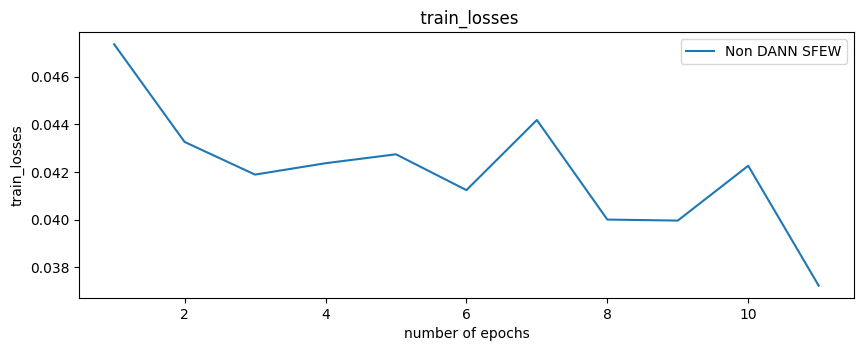

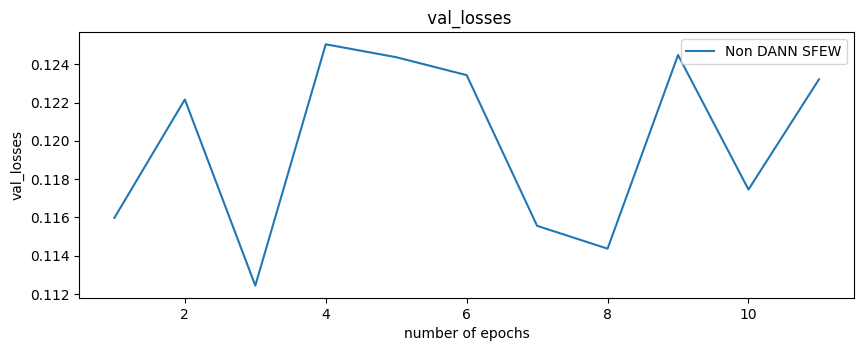

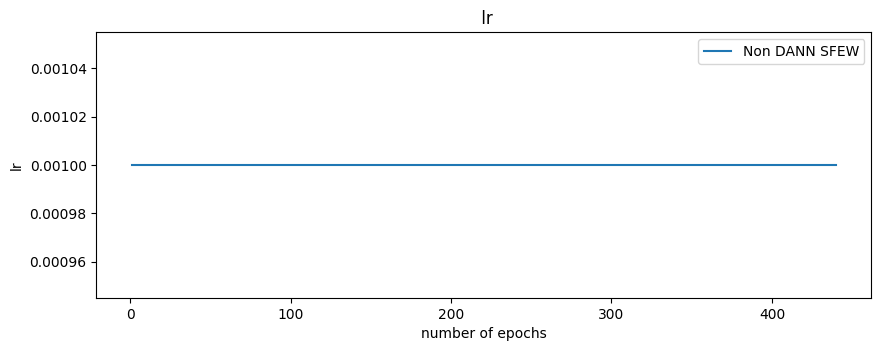

In [46]:
plot_loss_curves(dict_dann_losses,mode='train_losses')
plot_loss_curves(dict_dann_losses,mode='val_losses')
plot_loss_curves(dict_dann_losses,mode='lr')
# plot_loss_curves(dict_dann_losses,mode='list_alpha')


### Saving DANN Model

In [48]:
model_dann

DANNBespoke(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=

In [49]:
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR
MODEL_DIR

PosixPath('/content/gdrive/MyDrive/CV_FER/models')

In [50]:

dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))
# try:
#     DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
# except:
#     DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(model_dann.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


dann_sfew_expw_25_02.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_25_02.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_25_02.pt!


## DANN EWC : Training, Validating, Saving

In [ ]:
# dataconfig_inference = DataConfig()

# # NON DANN
# non_dann_model_sfew_name = 'non_dann_sfew_20_01.pt'
# non_dann_model_inference = DANN(num_classes=7) # skeleton copy
# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

# try:
#     non_dann_model.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
#                                                         map_location=torch.device(device)))
#     print(f'{non_dann_model_sfew_name} locked and loaded')
# except:
#     print(f' problem in loading {non_dann_model_sfew_name}')


In [ ]:
# model_dann_ewc = non_dann_model # saves training time - check with all


In [51]:
model_dann_ewc

DANNBespoke(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=

### EWC Code
Regularization Penalty

In [52]:

from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

**DANN EWC Object.**

In [53]:
# ewc_object = EWC(deepcopy(model_dann_ewc),
#                  data_loader=data_loader['source']['train'],#sfew_train_loader,
#                  device=device,
#                  class_loss_function=runconfig.criterion_class)

### DANN EWC Execution (training and testing) Function without Learning rate
Training Function

In [57]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(non_dann_model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses





### DANN EWC Execute

In [58]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr/5.0 #override
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
n_epochs = 40 # override

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model=model_dann,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = None,
                                                          early_stop_patience = None,
                                                          early_stop_difference = None)

0.4
------------training started for EWC DANN Model ------------------
epoch = 1...in EWC DANN execution function
Epoch [1/40] Step [1/41]: loss_total=1.9915 / domain_loss_target=0.6882 / domain_loss_source=0.6892 / task_loss=0.6141 / domain_loss=1.3032 / alpha=0.0000 / lr=0.001000
Test / Val: Average loss: 0.1158, Accuracy: 186/419 (44.39%)

last correct =186 | best correct = 0
Updated the best model with correct: 186

epoch = 2...in EWC DANN execution function
Epoch [2/40] Step [1/41]: loss_total=2.4168 / domain_loss_target=0.6928 / domain_loss_source=0.6950 / task_loss=1.0291 / domain_loss=1.7241 / alpha=0.1244 / lr=0.001000
Test / Val: Average loss: 0.1110, Accuracy: 179/419 (42.72%)

last correct =179 | best correct = 186
epoch = 3...in EWC DANN execution function
Epoch [3/40] Step [1/41]: loss_total=1.7121 / domain_loss_target=0.6913 / domain_loss_source=0.6966 / task_loss=0.3242 / domain_loss=1.0208 / alpha=0.2449 / lr=0.001000
Test / Val: Average loss: 0.1102, Accuracy: 186/419

### DANN EWC Plotting and Validation

In [59]:
dict_ewc_dann_losses['test_loss_source'], dict_ewc_dann_losses['test_loss_target']

(0.1083089514393226, 0.3100723238552318)

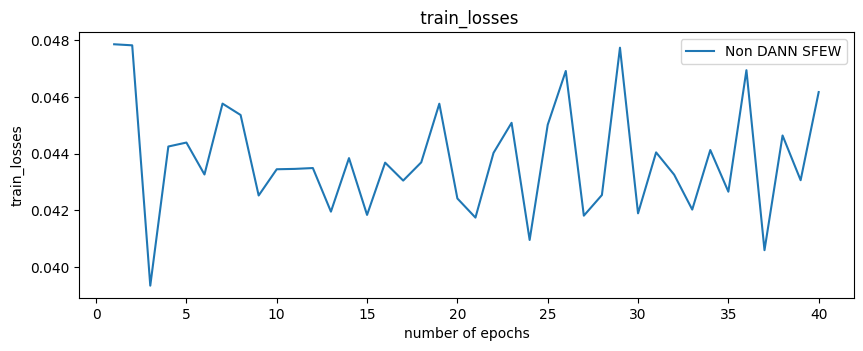

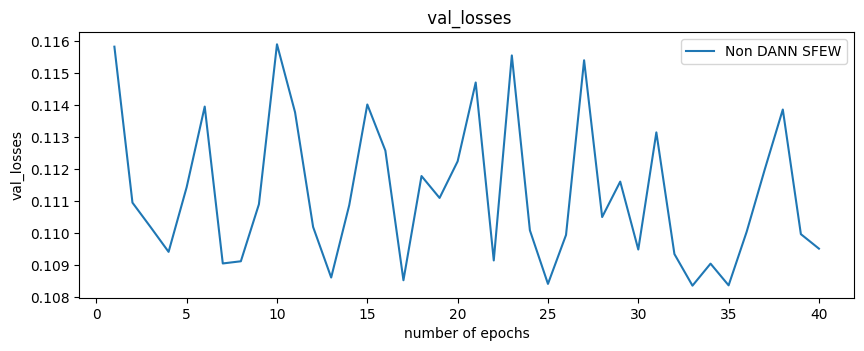

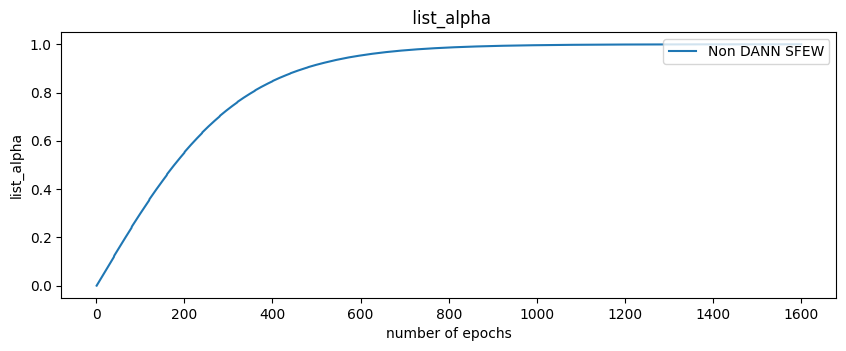

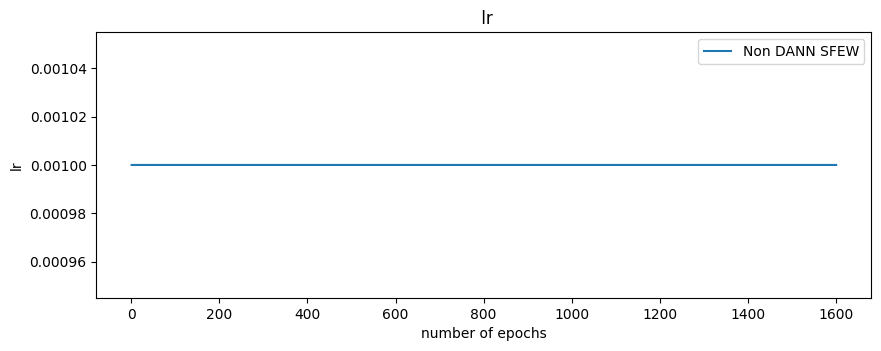

In [60]:
plot_loss_curves(dict_ewc_dann_losses,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='list_alpha')
plot_loss_curves(dict_ewc_dann_losses,mode='lr')

### Saving DANN EWC Model

In [61]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))
# try:
#     EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
# except:
#     EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")


if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')


ewc_dann_sfew_expw_25_02.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_25_02.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_25_02.pt!
